In [1]:
!pip install pandas

In [2]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom Dataset Class
class CustomSiameseDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        self._prepare_data()

    def _prepare_data(self):
        self.idx_0_images = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('_0.png')]
        self.idx_1_images = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('_1.png')]
        self.idx_0_images.sort()
        self.idx_1_images.sort()

        for idx in range(len(self.idx_0_images)):
            self.pairs.append((self.idx_0_images[idx], self.idx_1_images[idx], 1))
            random_idx = random.choice([i for i in range(len(self.idx_1_images)) if i != idx])
            self.pairs.append((self.idx_0_images[idx], self.idx_1_images[random_idx], 0))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path).convert("L")
        img2 = Image.open(img2_path).convert("L")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32), img1_path, img2_path


In [3]:
# for i, (img1_batch, img2_batch, label_batch, img1_paths, img2_paths) in enumerate(train_loader):
#     print(f"Batch {i+1}:")
    
#     for j in range(len(img1_batch)):  # Loop through the batch
#         if label_batch[j].item() != 1:
#             continue
#         print(f"  Pair {j+1} in Batch {i+1}:")
#         print(f"    Image 1: {img1_paths[j]}")
#         print(f"    Image 2: {img2_paths[j]}")
#         print(f"    Label: {int(label_batch[j].item())}")
        
#         # Optionally, visualize
#         show_image_pair(img1_batch[j], img2_batch[j], label_batch[j])
        
#         if j == 4:  # Limit to 5 pairs for inspection
#             break
#     break  # Inspect only the first batch


In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 64)  # Embedding size
        )

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, dim=1)  # Normalize embeddings

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [5]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = (label) * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_f1_score(model, data_loader, threshold=0.5):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (img1, img2, label, _, _) in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            distances = F.pairwise_distance(output1, output2)
            predictions = (distances < threshold).float()  # Threshold for similarity
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    return precision, recall, f1


In [7]:
# Initialize model, criterion, and optimizer
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
from torch.utils.data import random_split
from sklearn.model_selection import KFold

# Define transforms for images
transform = transforms.Compose([transforms.ToTensor()])

# Initialize the dataset
dataset = CustomSiameseDataset(data_dir="./data", transform=transform)

# Split dataset into train_val and test sets
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)  # 20% for testing
train_val_size = dataset_size - test_size

train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Set up k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for (img1, img2, label, _, _) in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            distances = F.pairwise_distance(output1, output2)
            predictions = (distances < 0.5).float()  # Threshold for similarity
            correct += (predictions == label).sum().item()
            total += label.size(0)
    return correct / total

def evaluate_f1_score(model, data_loader, threshold=0.5):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (img1, img2, label, _, _) in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            distances = F.pairwise_distance(output1, output2)
            predictions = (distances < threshold).float()  # Threshold for similarity
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    return precision, recall, f1


In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

num_epochs = 5
fold_train_losses = []
fold_val_losses = []
fold_metrics = []  # List to store metrics for each fold and epoch

for fold, (train_indices, val_indices) in enumerate(kf.split(range(len(train_val_dataset)))):
    print(f"Starting Fold {fold+1}/{k_folds}...")

    # Create DataLoaders for this fold
    train_subset = Subset(train_val_dataset, train_indices)
    val_subset = Subset(train_val_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Reinitialize model and optimizer for each fold
    model = SiameseNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Track losses for this fold
    train_losses = []
    val_losses = []
    fold_epoch_metrics = []  # Store metrics for each epoch

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for (img1, img2, label, _, _) in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for (img1, img2, label, _, _) in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                output1, output2 = model(img1, img2)
                loss = criterion(output1, output2, label)
                epoch_val_loss += loss.item()

                # Collect predictions for metrics
                distances = F.pairwise_distance(output1, output2)
                predictions = (distances < 0.5).float()  # Threshold for similarity
                all_labels.extend(label.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
        val_losses.append(epoch_val_loss / len(val_loader))

        # Calculate metrics
        accuracy = sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
        precision = precision_score(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)

        # Save metrics for this epoch
        fold_epoch_metrics.append({
            "epoch": epoch + 1,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "train_loss": train_losses[-1],
            "val_loss": val_losses[-1],
        })

        print(f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1: {f1:.4f}")

    # Store fold metrics
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_metrics.append(fold_epoch_metrics)


Starting Fold 1/5...
Fold 1, Epoch 1/5: Train Loss: 0.2407, Val Loss: 0.2192, Accuracy: 0.6356, Precision: 0.6223, Recall: 0.6548, F1: 0.6381
Fold 1, Epoch 2/5: Train Loss: 0.1931, Val Loss: 0.1873, Accuracy: 0.7175, Precision: 0.7459, Recall: 0.6433, F1: 0.6908
Fold 1, Epoch 3/5: Train Loss: 0.1710, Val Loss: 0.1712, Accuracy: 0.7650, Precision: 0.7553, Recall: 0.7707, F1: 0.7629
Fold 1, Epoch 4/5: Train Loss: 0.1553, Val Loss: 0.1739, Accuracy: 0.7431, Precision: 0.6851, Recall: 0.8815, F1: 0.7710
Fold 1, Epoch 5/5: Train Loss: 0.1451, Val Loss: 0.1570, Accuracy: 0.7856, Precision: 0.8113, Recall: 0.7338, F1: 0.7706
Starting Fold 2/5...
Fold 2, Epoch 1/5: Train Loss: 0.2391, Val Loss: 0.2078, Accuracy: 0.6681, Precision: 0.6934, Recall: 0.6117, F1: 0.6500
Fold 2, Epoch 2/5: Train Loss: 0.1964, Val Loss: 0.1802, Accuracy: 0.7362, Precision: 0.7487, Recall: 0.7171, F1: 0.7326
Fold 2, Epoch 3/5: Train Loss: 0.1695, Val Loss: 0.1662, Accuracy: 0.7762, Precision: 0.8077, Recall: 0.7295, F

In [13]:
def compute_average_cross_validated_metrics(fold_metrics):
    metrics_list = []
    for fold_idx, metrics in enumerate(fold_metrics):
        for epoch_metrics in metrics:
            metrics_list.append({
                "Fold": fold_idx + 1,
                **epoch_metrics  # Unpack epoch metrics
            })
    
    metrics_df = pd.DataFrame(metrics_list)

    # Compute average metrics for the last epoch of each fold
    avg_metrics = metrics_df.groupby("Fold").last().mean()
    avg_metrics = avg_metrics[["accuracy", "precision", "recall", "f1", "train_loss", "val_loss"]]
    return avg_metrics

average_cv_metrics = compute_average_cross_validated_metrics(fold_metrics)
print("Average Cross-Validated Metrics:")
print(average_cv_metrics)


Average Cross-Validated Metrics:
accuracy      0.792500
precision     0.811231
recall        0.762646
f1            0.784983
train_loss    0.144374
val_loss      0.156239
dtype: float64


In [15]:
def compute_test_metrics(model, test_loader):
    precision, recall, f1 = evaluate_f1_score(model, test_loader)
    accuracy = calculate_accuracy(model, test_loader)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [16]:
final_train_loader = DataLoader(train_val_dataset, batch_size=32, shuffle=True)
final_model = SiameseNetwork().to(device)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    final_model.train()
    for (img1, img2, label, _, _) in final_train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = final_model(img1, img2)
        loss = criterion(output1, output2, label)
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_metrics = compute_test_metrics(final_model, test_loader)

print("\nTest Set Metrics:")
print(test_metrics)



Test Set Metrics:
{'accuracy': 0.818, 'precision': 0.8171206225680934, 'recall': 0.8267716535433071, 'f1': 0.821917808219178}


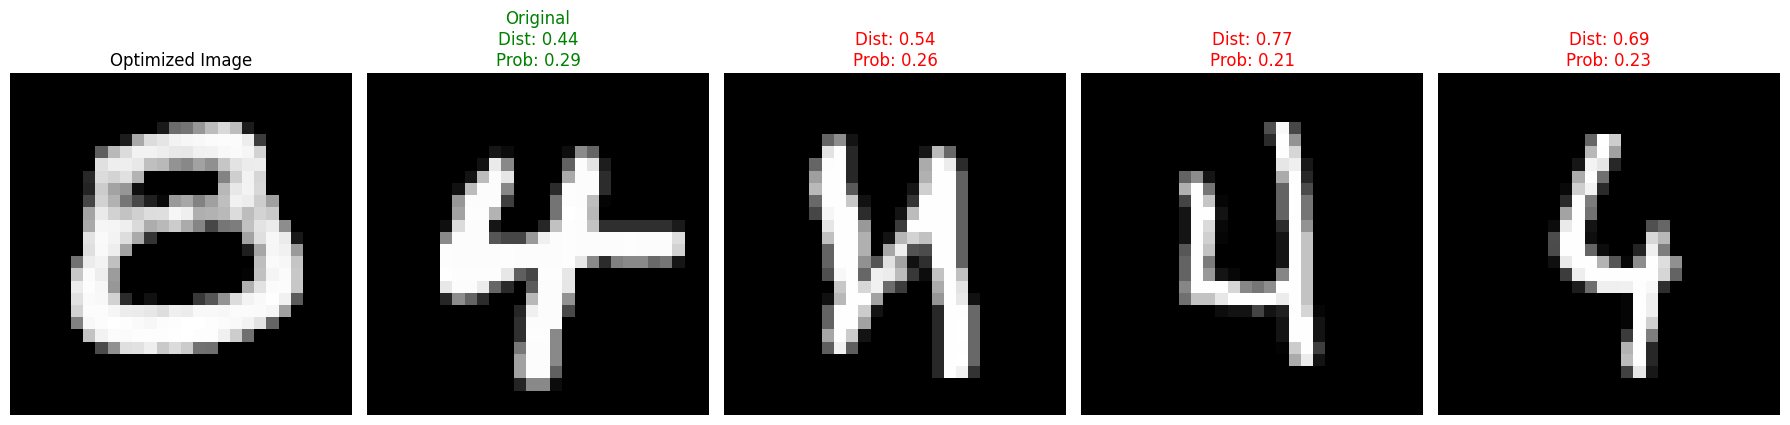

In [46]:
import random
import matplotlib.pyplot as plt

# Define a function to process one random example
def process_true_random_example(test_loader, model, device):
    # Flatten all label 1 pairs from the entire test set
    all_label_1_pairs = []
    all_pairs = []

    for batch_idx, (batch_img1, batch_img2, batch_labels, _, _) in enumerate(test_loader):
        for idx in range(len(batch_labels)):
            pair = (batch_img1[idx], batch_img2[idx], batch_labels[idx])
            all_pairs.append(pair)  # Add every pair
            if batch_labels[idx].item() == 1:  # Add label 1 pairs
                all_label_1_pairs.append(pair)

    if not all_label_1_pairs:
        raise ValueError("No label 1 pairs found in the test set!")

    # Randomly select one true original-optimized pair (label 1)
    true_pair = random.choice(all_label_1_pairs)
    true_original_img, optimized_img, _ = true_pair

    # Select 3 unique distractors that do not include the true original
    distractor_imgs = []
    while len(distractor_imgs) < 3:
        random_pair = random.choice(all_pairs)
        random_distractor = random_pair[0]  # Use the first image as the distractor
        # Ensure the random distractor is not the true original and not a duplicate
        if torch.equal(true_original_img, random_distractor):
            continue  # Skip if it's the true original
        if any(torch.equal(random_distractor, distractor) for distractor in distractor_imgs):
            continue  # Skip if it's already in the distractor list
        distractor_imgs.append(random_distractor)

    # Create pairs: (true original + optimized) and (randoms + optimized)
    pairs = [(true_original_img, optimized_img)] + [(distractor, optimized_img) for distractor in distractor_imgs]

    # Pass through the model and calculate distances
    model.eval()
    distances = []
    with torch.no_grad():
        for img1, img2 in pairs:
            img1, img2 = img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device)
            output1, output2 = model(img1, img2)
            distances.append(F.pairwise_distance(output1, output2).item())

    # Convert distances to probabilities
    probs = F.softmax(-torch.tensor(distances), dim=0).tolist()

    # Return the processed data
    return {
        "true_original_img": true_original_img,
        "optimized_img": optimized_img,
        "distractor_imgs": distractor_imgs,
        "distances": distances,
        "probs": probs,
    }



# Use this function for random selection
result = process_true_random_example(test_loader, model, device)

# Visualize the result
true_original_img = result["true_original_img"]
optimized_img = result["optimized_img"]
distractor_imgs = result["distractor_imgs"]
distances = result["distances"]  # Use distances
probs = result["probs"]          # Use probabilities

fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Display the optimized image
axes[0].imshow(optimized_img.squeeze().cpu().numpy(), cmap="gray")
axes[0].set_title("Optimized Image")
axes[0].axis("off")

# Display true original and distractor images with distances and probabilities
for j, (img, dist, prob) in enumerate(zip([true_original_img] + distractor_imgs, distances, probs)):
    if j == 0:  # True original
        axes[j + 1].imshow(img.squeeze().cpu().numpy(), cmap="gray")
        axes[j + 1].set_title(f"Original\nDist: {dist:.2f}\nProb: {prob:.2f}", color="green")
    else:  # Distractors
        axes[j + 1].imshow(img.squeeze().cpu().numpy(), cmap="gray")
        axes[j + 1].set_title(f"Dist: {dist:.2f}\nProb: {prob:.2f}", color="red")
    axes[j + 1].axis("off")

plt.tight_layout()
plt.show()
